<a href="https://colab.research.google.com/github/minhdinh03/FlowerClassificationProject/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, Model
from typing import Tuple
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
tf.compat.v1.enable_eager_execution()


os.environ["cuda_visible_devices"]="0" 

from glob import glob
import io
from PIL import Image

import math, re, os
import numpy as np

from collections import Counter

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.0-dev20220115


In [ ]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""PREPROCESSING"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'PREPROCESSING'

In [ ]:
IMAGE_SIZE = [224, 224]
PATH = 'C:/Users/Dat Nguyen/Desktop/Assignments/Machine Learning/New folder/combined_data_splitted'

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

TRAIN_PATH = tf.io.gfile.glob(PATH + '/train/*.tfrecord')
VAL_PATH = tf.io.gfile.glob(PATH + '/validation/*.tfrecord')
TEST_PATH = tf.io.gfile.glob(PATH + '/test/*.tfrecord')

In [ ]:
CLASSES = ['pink primrose',
 'wild geranium',
 'spear thistle',
 'yellow iris',
 'wallflower',
 'buttercup',
 'daisy',
 'common dandelion',
 'petunia',
 'sunflower',
 'iris',
 'windflower',
 'water lily',
 'rose',
 'morning glory',
 'frangipani',
 'cyclamen ',
 'foxglove',
 'common tulip',
 'wild rose']


In [ ]:

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   


def get_training_dataset(path = TRAIN_PATH, labeled = True):
    dataset = load_dataset(path)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(6536)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(path = VAL_PATH):
    dataset = load_dataset(path)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(path = TEST_PATH):
    dataset = load_dataset(path)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset


In [ ]:
ds_train = get_training_dataset()
ds_val = get_validation_dataset()
ds_test = get_test_dataset()

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""NETWORK DESIGN"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'NETWORK DESIGN'

In [ ]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
def resnet50():

  input_im = Input(shape=(224, 224, 3))
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(20, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [ ]:
model = resnet50()

In [ ]:
model.compile(optimizer='adam', loss = losses.sparse_categorical_crossentropy, metrics='accuracy' )

In [ ]:
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

                                                                                                  
 activation_8 (Activation)      (None, 55, 55, 64)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 55, 55, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 55, 55, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 55, 55, 256)  0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
          

 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 512)  0           ['batch_normalization_20[0][0]', 
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 28, 28, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 28, 28, 128)  512        ['conv2d_21[0][0]']              
 ormalizat

 add_8 (Add)                    (None, 14, 14, 1024  0           ['batch_normalization_30[0][0]', 
                                )                                 'activation_24[0][0]']          
                                                                                                  
 activation_27 (Activation)     (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 14, 14, 256)  262400      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_31 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_31[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_40 (Conv2D)             (None, 14, 14, 256)  262400      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_40 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 14, 14, 256)  0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 14, 14, 256)  590080      ['activation_37[0][0]']          
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 activation_46 (Activation)     (None, 7, 7, 512)    0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 512)   2048        ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_47 (Activation)     (None, 7, 7, 512)    0           ['batch_normalization_51[0][0]'] 
          

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta = 0.05, mode = "max" ,patience=15, restore_best_weights=True)
callbacks = [early_stop]
history = model.fit(ds_train, validation_data=ds_val, epochs=120, callbacks = callbacks)


Epoch 1/120
409/409 [==============================] - 142s 315ms/step - loss: 20.8365 - accuracy: 0.1570 - val_loss: 14.5566 - val_accuracy: 0.2214
Epoch 2/120
409/409 [==============================] - 128s 309ms/step - loss: 11.8367 - accuracy: 0.2399 - val_loss: 9.7741 - val_accuracy: 0.2736
Epoch 3/120
409/409 [==============================] - 128s 308ms/step - loss: 8.4602 - accuracy: 0.2829 - val_loss: 16.4092 - val_accuracy: 0.1614
Epoch 4/120
409/409 [==============================] - 129s 309ms/step - loss: 7.0221 - accuracy: 0.2941 - val_loss: 6.2626 - val_accuracy: 0.3250
Epoch 5/120
409/409 [==============================] - 128s 309ms/step - loss: 6.8332 - accuracy: 0.2528 - val_loss: 12.5686 - val_accuracy: 0.2029
Epoch 6/120
409/409 [==============================] - 129s 311ms/step - loss: 6.1874 - accuracy: 0.2917 - val_loss: 5.6634 - val_accuracy: 0.2836
Epoch 7/120
409/409 [==============================] - 128s 308ms/step - loss: 6.1919 - accuracy: 0.2877 - val_lo

409/409 [==============================] - 137s 311ms/step - loss: 1.3919 - accuracy: 0.6252 - val_loss: 1.9861 - val_accuracy: 0.5257
Epoch 57/120
409/409 [==============================] - 137s 312ms/step - loss: 1.3503 - accuracy: 0.6445 - val_loss: 1.7752 - val_accuracy: 0.5686
Epoch 58/120
409/409 [==============================] - 138s 312ms/step - loss: 1.3463 - accuracy: 0.6499 - val_loss: 2.5971 - val_accuracy: 0.4800
Epoch 59/120
409/409 [==============================] - 138s 312ms/step - loss: 1.2940 - accuracy: 0.6586 - val_loss: 1.9277 - val_accuracy: 0.5457
Epoch 60/120
409/409 [==============================] - 138s 312ms/step - loss: 1.2705 - accuracy: 0.6620 - val_loss: 3.3497 - val_accuracy: 0.4264
Epoch 61/120
409/409 [==============================] - 138s 311ms/step - loss: 1.2567 - accuracy: 0.6690 - val_loss: 2.2049 - val_accuracy: 0.5257
Epoch 62/120
409/409 [==============================] - 138s 311ms/step - loss: 1.2368 - accuracy: 0.6785 - val_loss: 2.0166 

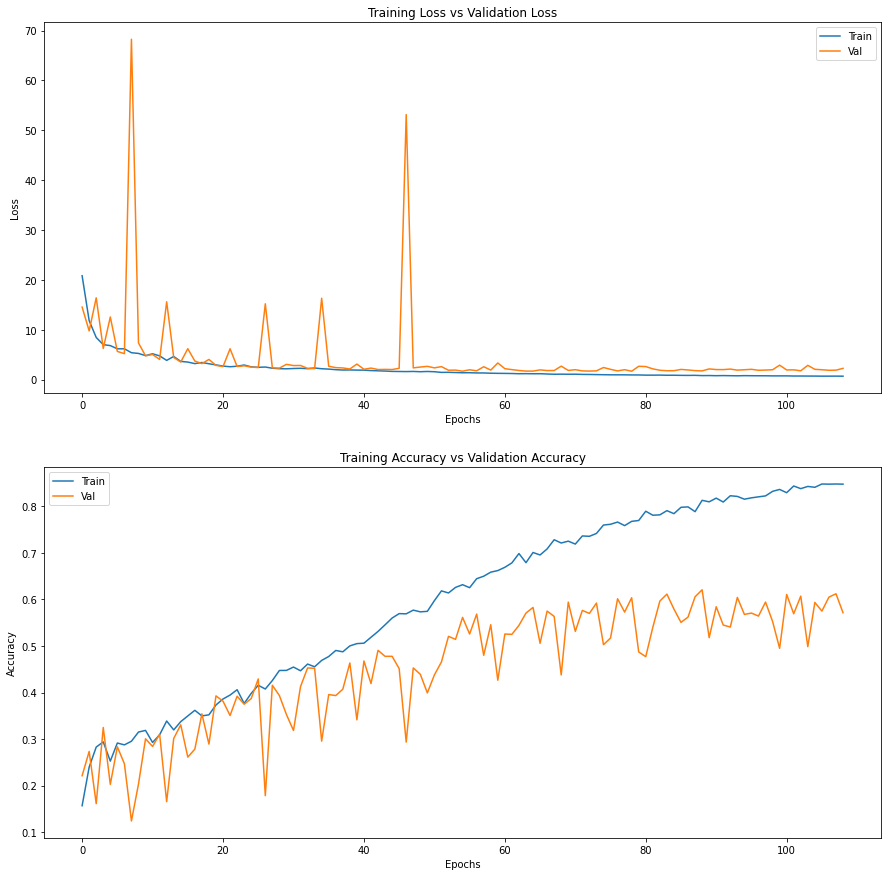

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.save("path_to_file")